# Comparison of motif similarity at embryonic stages.

We wanted to investigate if the two species display similarities in their cis-regulatory content.
As a first step, we will assess the similarity of developmental stages in the two species based on what TFs are important in them. This notebook contains a few supplementary plots regarding the data and statistical manipulations we apply.

For each experiment (stage), we look into the atac peaks and get counts of "motifs" (PWM significant hits)
for a large database of factors. We can then compare two stages based on those counts.
We can for example calculate the correlation between stages and thus, we created a heatmap of correlation for the developmental stages of the two species.

We counted motifs (PWMs) in dynamic ATAC peaks of our various developmental stages. We divided each motif's count by the total hits of the motif in all stages and then scaled the values in each stage.     

# Preparation

### Motif families

We have a large set of Position Weight Matrices, which we group together by their protein
e.g. AP-2_Average_15 and AP-2_Average_17 are different position weight matrices,
but both assigned to the 'Tfap2e' transcription factor so we will consider all instances
of these two PWMs as instances of Tfap2e.    
     
Another example, are ARID_BRIGHT_RFX_Average_2,ARID_BRIGHT_RFX_Average_3 and ARID_BRIGHT_RFX_M4343_1.02 :    
These 3 PWMs all are assigned to the TFs "Rfx1;Rfx2;Rfx4;Rfx7" so we will consider all instances of those 3 PWMs    
to be instances of a "Rfx1;Rfx2;Rfx4;Rfx7" protein family.
    
To accomplish this, we will make a dictionary that maps PWMs to Protein family names :

### The mapped motifs:

In [1]:
dan_motif_bed = BT("/home/ska/panos/myphdthesis/data/PWM/danre_pwm_hits.bed.gz")
bla_motif_bed = BT("/home/ska/panos/myphdthesis/data/PWM/bralan_pwm_hits.bed.gz")
bla_motif_bed.head(2)

Sc0000000	5593	5598	Homeodomain_Average_626	6.60757208173	+
 Sc0000000	5695	5707	C2H2_ZF_Average_154	10.8804149236	+
 

### The ATACseq peaks

We have compiled a set of peaks that turn ON or OFF in a reasonable pattern during development,
and called these peaks 'dynamic'.     
    
Per stage we will only consider these dynamic peaks.     
     
We load them in pyBedTool objects, BT().     
      
We load the stages from each stage, and keep the ones that have been marked 
as logicaldynamic

### ATAC dynamic peaks

ATACseq peak calling is performed individually in each experiment (developmental stage).
Some regions will be open in more than one stage, but due to the nature of the experiments, or because these open regions open slightly more or slightly less in different stages/tissues/cells, we cannot expect these regions to be called with perfectly accurate edges. In order then to track peaks from one stage to another, we considered peaks from different stages to be the "same peak" if they overlap. I.e., if we call a peak in stage 0, from base 10 to base 23 and then another peak in stage 1 from base 5 to base 21, we would consider these two peaks to be the same peak, having remained open for the two stages.

    stage 0
        chrX 10 23
    stage 1
        chrX 5 21
        chrX 50 55

We merged the peaks from all experiments to obtain a set of all regions we could consider a peak I.e., the two previously mentioned example peaks would be merged into one:

    merged peaks
    chrX 5 23
    chrX 50 55

We then consider each of those peaks as active or not active in the various stages depending on whether or not it overlaps with a peak from the stage.

    merged peaks
    chrX 5 23 <--- is active in both stages
    chrX 50 55 <--- is only active in stage 1

If we mark the activity of a peak with zeros and ones, we can summarize its activity. The "chrX 5 23" peak from our example would have "11" activity, and the other peak would have "01" activity. I.e., we have six developmental stages for zebrafish, so if a peak "turns on" in the third stage and then off again in the sixth stage, it would have activity: "001110".

We considered a subset of peaks as "logically dynamic" if they had one of the following activity profiles:

    '000011', '000110', '001100', '011000', '110000',
    '000111', '001110', '011100', '111000', 
    '001111', '011110', '111100', 
    '011111', '111110'

Peaks with only one active stage we considered "stage specific", and peaks that we always active were considered "constitutive".

In [2]:
# some helper functions to get the dynamic peaks per stage
a_dynamic = BT(
    "/home/ska/panos/myphdthesis/data/atac_peaks/amphi_logicaldynamic_idr.bed.gz")
def bla_stagepeaks(stage):
    sd = BT(amphi_idr(stage))
    sd = sd.intersect(a_dynamic,u=True, nonamecheck=True)  
    return sd.sort()

z_dynamic = BT(
    "/home/ska/panos/myphdthesis/data/atac_peaks/zebra_danRer10_logicaldynamic_idr.bed.gz")
def dan_stagepeaks(stage):
    sd = BT(zebra_idr(stage))
    sd = sd.intersect(z_dynamic,u=True, nonamecheck=True)
    return sd.sort()

amphi_stages = ['8','15','36','60','hep']
zebra_stages = ['dome','shield','80epi','8som','24h','48h']

bla_peaks = [bla_stagepeaks(stage) for stage in amphi_stages]
dan_peaks = [dan_stagepeaks(stage) for stage in zebra_stages]

In [3]:
dan_peaks = [BT().from_dataframe(x.to_dataframe().iloc[:,:3]) 
             for x in dan_peaks]
bla_peaks = [BT().from_dataframe(x.to_dataframe().iloc[:,:3]) 
             for x in bla_peaks]
bla_peaks[0].head(3)

Sc0000000	311943	312518
 Sc0000000	319117	319493
 Sc0000000	356649	356918
 

In [4]:
TFids = sorted(set(SFDu.values()))

In [5]:
# Here we get a dictionary, mapping the TF unique numbers to a total 
# count per organism
# We will use this to normalize later on
_temp = (BT(zebra_idr('merged'))
         .sort()                                                              
        .intersect(dan_motif_bed, loj=True, sorted=True, 
                   nonamecheck=True)   
        .to_dataframe())                                                     

# we then map the SFDu dictionary on the column carrying the PWM names, 
# drop empty rows,and get a count (with Counter, a handy python extension 
# of dictionaries) of each unique ID
dan_totals = Counter(_temp['thickStart'].map(SFDu).dropna().astype(int))

_temp = (BT(amphi_idr('merged'))
        .sort()
        .intersect(bla_motif_bed, loj=True, sorted=True, nonamecheck=True)
        .to_dataframe())
bla_totals = Counter(_temp['thickStart'].map(SFDu).dropna().astype(int))

# we cast the total counts in a list with a proper orger:
dan_normalizer = [dan_totals.get(x,1) for x in TFids]
bla_normalizer = [bla_totals.get(x,1) for x in TFids]

In [6]:
# the resulting DataFrame after the LOJ operation.
# for each ATAC peak,we get all its intersections with PWMs
_temp.head(2)

chrom  start   end       name  score  strand               thickStart  \
0  Sc0000000   5589  5975  Sc0000000   5593    5598  Homeodomain_Average_626   
1  Sc0000000   5589  5975  Sc0000000   5695    5707      C2H2_ZF_Average_154   

    thickEnd itemRgb  
0   6.607572       +  
1  10.880415       +

In [7]:
#dan_totals is a dictionary mapping the uniqueIds of PWMs to counts
list(dan_totals.items())[:3]

[(0, 3653), (1, 16725), (2, 1848)]

In [8]:
# The "normalizer" lists are derived from the dictionaries and are in 
# order of "TFids"
bla_normalizer[:3]

[1188, 3585, 930]

###  Mapping the motifs to peaks:    
     
We did this already to get the normalization counts, now we will do it 
with the stage dynamic peaks

In [9]:
# Here we make a dataframe per stage per organism
# Each DataFrame corresponds to one stage and maps motifs to the 
# peaks that were active on
# that stage. We use the LEFT OUTER JOIN function of bedtools to 
# join motifs to peaks:
bla_lojs = [(stage
                .sort()
                .intersect(bla_motif_bed, sorted=True, loj=True, 
                           nonamecheck=True)
                .to_dataframe()) for stage in bla_peaks]
dan_lojs = [(stage
                .sort()
                .intersect(dan_motif_bed, sorted=True, loj=True, 
                           nonamecheck=True)
                .to_dataframe()) for stage in dan_peaks]

In [10]:
# For example, the DF for the first stage of amphioxus:
bla_lojs[0].head(2)

chrom   start     end       name   score  strand  \
0  Sc0000000  311943  312518  Sc0000000  311942  311946   
1  Sc0000000  311943  312518  Sc0000000  312028  312035   

              thickStart  thickEnd itemRgb  
0    C2H2_ZF_Average_177  5.460094       +  
1  Grainyhead_M6529_1.02  7.510921       +

In [11]:
# Finally, we make a DF with counts for each TF in each stage:
# These are the counts in the dynamic peaks
ddf = pd.DataFrame(TFids)
ddf.columns = ['fam']

for en,stage in enumerate(zebra_stages):
    ddf[stage] = (ddf['fam']
                .map(Counter(dan_lojs[en]['thickStart']
                .dropna()
                .map(SFDu)
                .dropna()
                .astype(int))))
    
ddf.set_index('fam', inplace=True, drop=True)

ddf = ddf.T.fillna(1)
ddf.iloc[:,:4]

fam       0     1    2     3
dome    161   729   74   389
shield  409  1931  165  1014
80epi   638  2991  228  1657
8som    756  3693  298  2357
24h     785  3911  333  2504
48h     672  3333  335  2185

In [12]:
# And the same for amphioxus
bdf = pd.DataFrame(TFids)
bdf.columns = ['fam']
for en,stage in enumerate(amphi_stages):
    bdf[stage] = (bdf['fam']
                  .map(Counter(bla_lojs[en]['thickStart']
                               .dropna()
                               .map(SFDu)
                               .dropna()
                               .astype(int))))
    
bdf.set_index('fam', inplace=True, drop=True)

bdf = bdf.T.fillna(1)
bdf.iloc[:,:4]

fam    0    1    2     3
8     73  257   50   251
15   196  618  172   707
36   219  652  177   942
60   236  761  217  1155
hep  212  608  144   998

In [13]:
# we divide the count in each stage by the total count
bdf = bdf/bla_normalizer
ddf = ddf/dan_normalizer
bdf.iloc[:,:4]

fam         0         1         2         3
8    0.061448  0.071688  0.053763  0.052129
15   0.164983  0.172385  0.184946  0.146833
36   0.184343  0.181869  0.190323  0.195639
60   0.198653  0.212273  0.233333  0.239875
hep  0.178451  0.169596  0.154839  0.207269

In [14]:
# At this point, some TFs have 0 counts, so lets clean them out:
btodrop = set(bdf.T[bdf.sum() ==0].index.values)
dtodrop = set(ddf.T[ddf.sum() ==0].index.values)

todrop = btodrop.union(dtodrop)

bdf = bdf.drop(todrop, axis=1)
ddf = ddf.drop(todrop, axis=1)

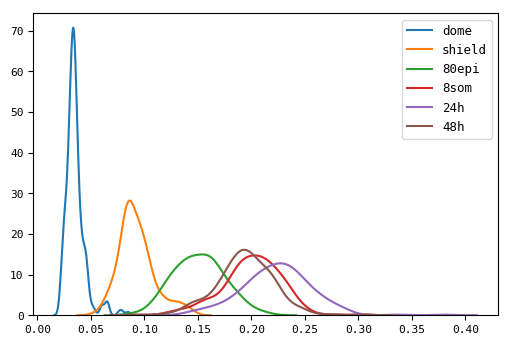

In [15]:
# the distributions of the various stages at this point:
for irow,row in ddf.iterrows():
    sns.kdeplot(row)

In [16]:
# let's scale the counts in order to make stages comparable
ddf.loc[:,:] = preprocessing.scale(ddf.values, axis=1)
bdf.loc[:,:] = preprocessing.scale(bdf.values, axis=1)

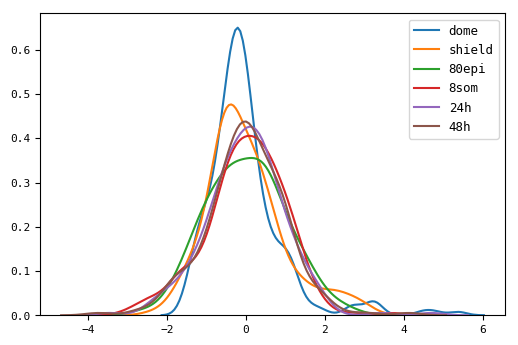

In [17]:
# the distributions after scaling:
for irow,row in ddf.iterrows():
    sns.kdeplot(row)

## The final table:
In the end, we have a scaled count per motif for each organism-stage.
For example the first 5 TF scaled counts in zebrafish-shield look like this:

In [18]:
ddf.loc['shield',:].head(3)

fam
0    1.143067
1    1.350141
2   -0.201232
Name: shield, dtype: float64

We can then get a corellation between any two cases

In [19]:
scaled_counts_in_zebra_shield = ddf.loc['shield',:]
scaled_counts_in_amphi_hep = bdf.loc['hep',:]
# The first value is the pearson metric and the second is 
# the metric's pvalue,how certain we are for the metric.
pearsonr(scaled_counts_in_zebra_shield.values, 
         scaled_counts_in_amphi_hep.values)

(-0.18212360335862862, 0.004478666595009111)

In [20]:
# We can make a table with pair-wise correlations for all stages
TABLE = pd.DataFrame()
for dstage in zebra_stages:
    for bstage in amphi_stages:
        TABLE.loc[dstage, bstage] = pearsonr(
            ddf.loc[dstage].values,bdf.loc[bstage].values)[0]
TABLE

8        15        36        60       hep
dome    0.472447  0.413344 -0.020947 -0.233493 -0.217931
shield  0.427724  0.620226  0.304749 -0.079934 -0.182124
80epi   0.248738  0.577668  0.509119  0.113895 -0.064038
8som   -0.016492  0.297138  0.525042  0.289232  0.156917
24h    -0.091795  0.182115  0.427101  0.263281  0.264657
48h    -0.225320  0.018198  0.359862  0.292274  0.196003

In [21]:
# We can make a table with pair-wise correlations for all stages
TABLE_pvals = pd.DataFrame()
for dstage in zebra_stages:
    for bstage in amphi_stages:
        TABLE_pvals.loc[dstage, bstage] = pearsonr(
            ddf.loc[dstage].values,bdf.loc[bstage].values)[1]
TABLE_pvals

8            15            36        60       hep
dome    7.373361e-15  2.101586e-11  7.457777e-01  0.000248  0.000641
shield  3.487620e-12  4.056149e-27  1.354005e-06  0.215337  0.004479
80epi   9.188728e-05  6.117028e-23  2.309811e-17  0.076998  0.321167
8som    7.985353e-01  2.536864e-06  1.510216e-18  0.000005  0.014542
24h     1.545583e-01  4.480531e-03  3.776619e-12  0.000034  0.000030
48h     4.115778e-04  7.782047e-01  8.243826e-09  0.000004  0.002191

We can visualize the table in a heatmap:

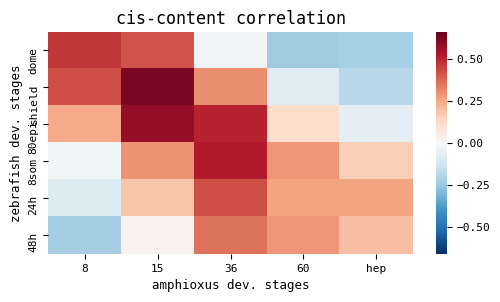

In [22]:
Fwidth = THESIS_PAGEWIDTH
Fheight = Fwidth*(9/16.)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.11, bottom=.15, right=1, top=.92)

# ax.set_title('ATACseq peak numbers overview')
sns.heatmap(TABLE,
            annot=False,
            cmap="RdBu_r",
            vmax=0.66, vmin=-0.66,
            ax=ax
           )
ax.set_title("cis-content correlation")
#>>> Name your Axes
ax.set_ylabel('zebrafish dev. stages')
ax.set_xlabel('amphioxus dev. stages')
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_phyloheat.pdf')

Or we can plot the minimum distance per amphioxus stage, to show the hourglass behaviour

In [23]:
x = [ 0, 1, 2, 3, 4]
labels = ['8h','15h','36h','60h','hepatic']

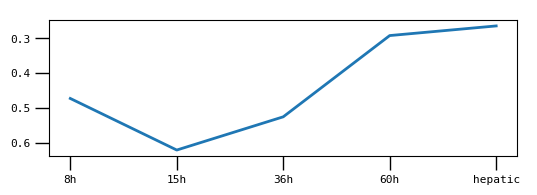

In [24]:
Fwidth = THESIS_PAGEWIDTH
Fheight = Fwidth/3

fig, ax = plt.subplots()
fig.subplots_adjust(left=.075, bottom=.17, right=0.99,
                    top=.97)

# ax.set_title('ATACseq peak numbers overview')
ax.plot( TABLE.max().values, linewidth=2)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params(direction ='out',
               length=10, width=1, colors='black')
ax.invert_yaxis()

# ax.set_title("cis-content correlation")
#>>> Name your Axes
# ax.set_ylabel('zebrafish dev. stages')
# ax.set_xlabel('amphioxus dev. stages')
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")
fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_phyloline.pdf')